# Code file for CA3
### Part 1) Plot predicted and true stock price on a test set

## Moving Average (MA)

In this part, we use AR model to predict Apple's stock price. Again, the data is from Apple.Inc (one year: from 28/Dec/2020 to 27/Dec/2021). In order to help you gain the insights of AR model, instead of using exsiting Python Statsmodels library (https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html), I tend to show an example to implement AR from scratch. Addtionally, you can use this Statsmodels library to test performance by yourself. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

/Users/Cam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/Cam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [ ]:
df=pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col=['Date'], dayfirst=True)
df.columns=['Actual']
df

,Actual
Date,
2021-01-04,3186.629883
2021-01-05,3218.510010
2021-01-06,3138.379883
2021-01-07,3162.159912
2021-01-08,3182.699951
...,...
2021-12-23,3421.370117
2021-12-27,3393.389893
2021-12-28,3413.219971


In [ ]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Actual'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Actual'], df_test['Predicted']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

From the figure of PACF, we can use 2 as the lag number.

In [ ]:
lag_num = 2

#Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [ ]:
[df_train,df_test,theta,intercept,RMSE] = AR(2,pd.DataFrame(df.Actual))

The RMSE is : 55.20456800860882 , Value of p :  2


In [ ]:
df_c = pd.concat([df_train,df_test])
res = pd.DataFrame()
res['Residuals'] = df_c.Actual - df_c.Predicted

In [ ]:
res['Residuals']

Date
2021-01-06   -90.243581
2021-01-07    23.796398
2021-01-08     8.529906
2021-01-11   -79.018346
2021-01-12     3.893725
                ...    
2021-12-23     3.520477
2021-12-27   -23.554794
2021-12-28    26.452209
2021-12-29   -27.649090
2021-12-30    -4.839605
Name: Residuals, Length: 249, dtype: float64

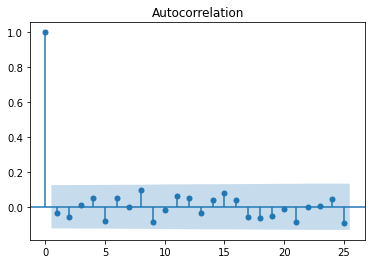

In [ ]:
ACF = plot_acf(res['Residuals'],lags=25)

In [ ]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]

The RMSE is : 55.81297191448571 , Value of q :  1
The RMSE is : 55.673831685308436 , Value of q :  2
The RMSE is : 55.73569078545835 , Value of q :  3
The RMSE is : 56.55373699787079 , Value of q :  4
The RMSE is : 56.58488503643921 , Value of q :  5
The RMSE is : 56.4779278230804 , Value of q :  6
The RMSE is : 56.65510564232973 , Value of q :  7
The RMSE is : 56.251596117939805 , Value of q :  8
The RMSE is : 56.19038060047284 , Value of q :  9
The RMSE is : 55.98701959747327 , Value of q :  10
The RMSE is : 55.865226618790075 , Value of q :  11
The RMSE is : 56.19551888347406 , Value of q :  12
2


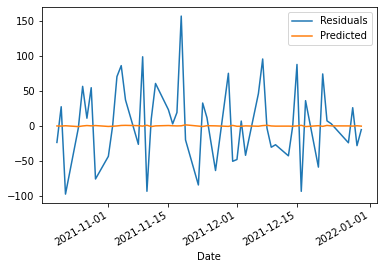

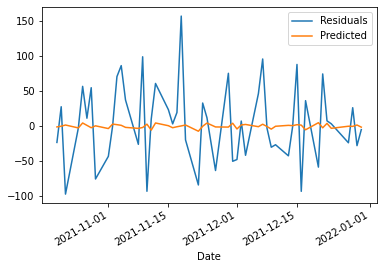

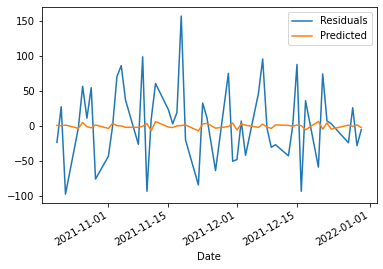

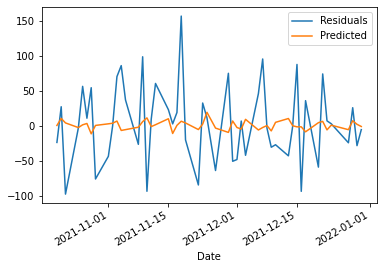

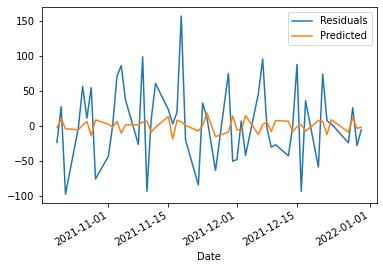

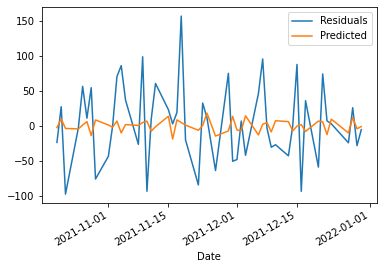

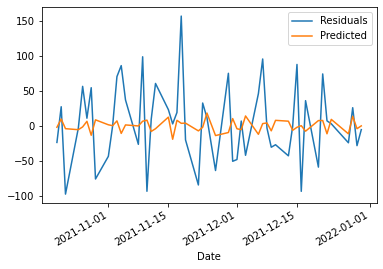

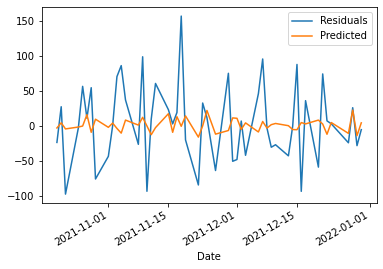

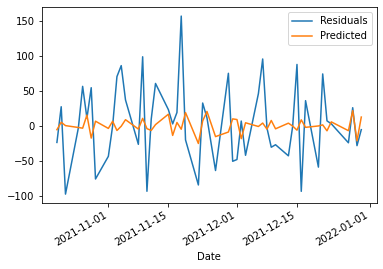

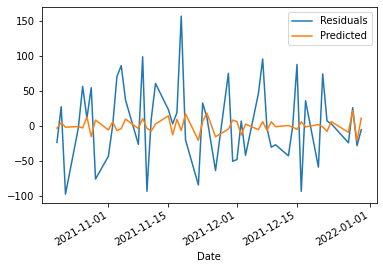

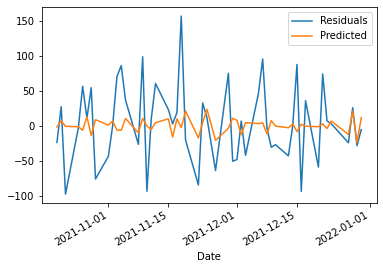

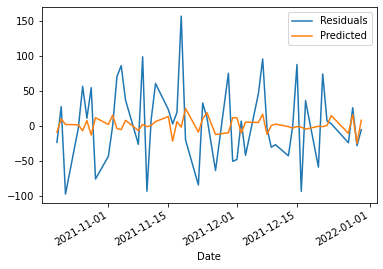

In [ ]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The RMSE is : 55.673831685308436 , Value of q :  2
[[ 0.01488263]
 [-0.04530506]]
[0.31610141]


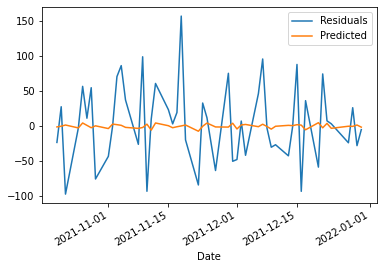

In [ ]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [ ]:
df_test = df_test.iloc[1:]
df_test.Predicted = df_test.Predicted + res_test.Predicted
df_test.head()


,Actual,Shifted_values_1,Shifted_values_2,Predicted
Date,,,,
2021-10-21,3435.010010,3415.060059,3444.149902,3407.257972
2021-10-22,3335.550049,3435.010010,3415.060059,3435.892365
2021-10-25,3320.370117,3335.550049,3435.010010,3318.040755
2021-10-26,3376.070068,3320.370117,3335.550049,3328.509126
2021-10-27,3392.489990,3376.070068,3320.370117,3383.576577


AttributeError: 'DataFrame' object has no attribute 'set_ylabel'

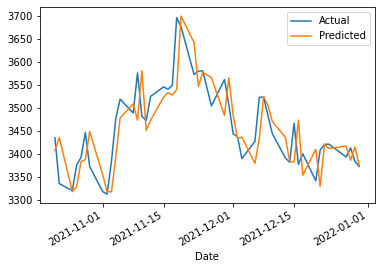

In [ ]:
df_test[['Actual','Predicted']].plot()
df_test[['Actual','Predicted']].set_ylabel('s1 and s2')

RMSE = np.sqrt(mean_squared_error(df_test['Actual'], df_test['Predicted']))
print(RMSE)

## Augmented Dickey–Fuller test 

In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [ ]:
df_ADF = pd.read_csv('AMZN.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
adf_check(df_ADF)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.6228559132272875
p-value : 0.08836482157882364
Number of Lags Used : 0
Number of Observations Used : 250
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



/Users/Cam/opt/anaconda3/lib/python3.8/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '13/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/Cam/opt/anaconda3/lib/python3.8/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '14/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/Cam/opt/anaconda3/lib/python3.8/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '15/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/Users/Cam/opt/anaconda3/lib/python3.8/site-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '19/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.t

In [ ]:
df_ADF['Actual'] = df_ADF['Actual'].diff().diff()
df_ADF = df.drop(df.index[[0,1]])
df_ADF
adf_check(df)

KeyError: 'Actual'

# GARCH for Volatility Prediction

## Read Data

In [ ]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Case study: Apple stock price

In [ ]:
# set the start date and the end date you would like to study
# start = datetime("2010-01-01")
# end = datetime("2020-06-10")
start = "2010-01-01"
end = "2020-06-10"

In [ ]:
# extract data from various Internet sources into a pandas DataFrame.
# Not limited with finance data from Yahoo, it provides other popular data sources (e.g., world bank, Naver).
# See details: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
amzn = web.DataReader('AMZN', 'yahoo', start=start, end=end)

In [ ]:
# calculate volatility of returns by the function pct_change()
# For more details about why view percentage change as volatility: https://finance.zacks.com/price-change-vs-volatility-7592.html
returns = 100 * amzn.Actual.pct_change().dropna()

Text(0.5, 1.0, 'AMZN Returns')

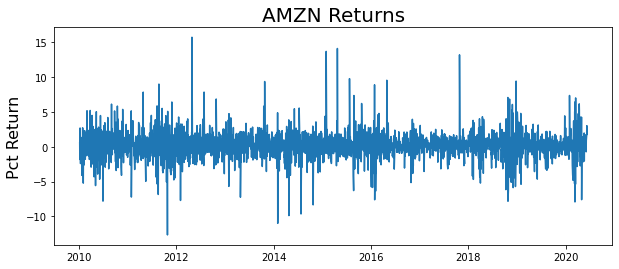

In [ ]:
# visualise PCT return that is the percentage change from the immediately previous row by default
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('AMZN Returns', fontsize=20)

## PACF

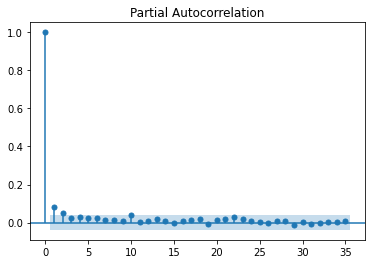

In [ ]:
# calculate the PACF with the variance of return as an input
plot_pacf(returns**2, method='ywm')
plt.show()

## Fit GARCH(3,3)

In [ ]:
# A GARCH model subsumes ARCH models, where a GARCH(0, q) is equivalent to an ARCH(q) model.
model = arch_model(returns, p=3, q=3)

In [ ]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 12669.536095491876
Iteration:      2,   Func. Count:     22,   Neg. LLF: 1857669.898831361
Iteration:      3,   Func. Count:     32,   Neg. LLF: 5702.381854289319
Iteration:      4,   Func. Count:     43,   Neg. LLF: 5647.017863413162
Iteration:      5,   Func. Count:     53,   Neg. LLF: 5613.460840005607
Iteration:      6,   Func. Count:     63,   Neg. LLF: 5412.480744187382
Iteration:      7,   Func. Count:     73,   Neg. LLF: 5585.778343354617
Iteration:      8,   Func. Count:     83,   Neg. LLF: 5408.580696405868
Iteration:      9,   Func. Count:     93,   Neg. LLF: 5457.619922157221
Iteration:     10,   Func. Count:    103,   Neg. LLF: 5415.194605360837
Iteration:     11,   Func. Count:    113,   Neg. LLF: 5401.02758106496
Iteration:     12,   Func. Count:    122,   Neg. LLF: 5408.721382683436
Iteration:     13,   Func. Count:    132,   Neg. LLF: 5401.2866054897395
Iteration:     14,   Func. Count:    142,   Neg. LLF: 5400.2850

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5400.27
Distribution:                  Normal   AIC:                           10816.5
Method:            Maximum Likelihood   BIC:                           10863.5
                                        No. Observations:                 2626
Date:                Thu, Mar 03 2022   Df Residuals:                     2625
Time:                        17:00:36   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1937  5.261e-02      3.681  2.322e-04 [9.055e-02,  0.297]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.6237      0.187      3.332  8.611e-04      [  0.257,  0.991]
alpha[1]       0.2316  5.524e-02      4.192  2.759e-05      [  0.123,  0.340]
alpha[2]       0.0365      0.110      0.331      0.740      [ -0.179,  0.252]
alpha[3]       0.0000  5.032e-02      0.000      1.000 [-9.863e-02,9.863e-02]
beta[1]        0.0000      0.317      0.000      1.000      [ -0.621,  0.621]
beta[2]        0.0000      0.168      0.000      1.000      [ -0.329,  0.329]
beta[3]        0.6091      0.365      1.670  9.486e-02      [ -0.106,  1.324]
=============================================================================

Covariance estimator: robust
"""

# How to use the model

In [ ]:
train = returns
model = arch_model(train, p=2, q=2)
model_fit = model.fit(disp='off')

In [ ]:
from arch.__future__ import reindexing
pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

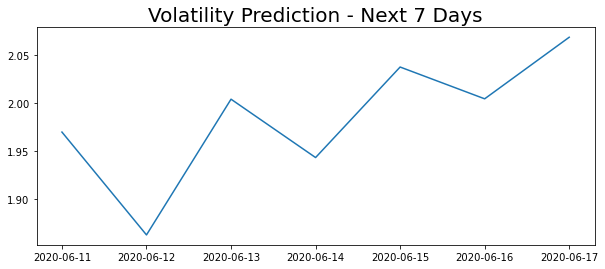

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)